### Data Sourcing
Obtain the data from 1 Oct 2012 to 30 September 2022 for the following: (say)
2012-10-01 to 2022-09-30
1. SPY (SPDR S & P 500 ETF)
2. XLE (Energy Sector SPDR)
3. VNQ (Real Estate)
4. XLF (Finance Sector SPDR)

In [61]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
import numpy as np
import plotly as plotly
from scipy.stats import lognorm,shapiro,normaltest,norm
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

In [62]:
yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
spy_df = pd.DataFrame(data['SPY']['prices'])
spy_df = spy_df.drop('date', axis=1).set_index('formatted_date')
spy_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,147.160004,143.830002,144.520004,146.139999,619770200,120.519821
2012-10-08,146.119995,142.580002,145.600006,142.889999,599319200,117.839561
2012-10-15,146.520004,142.770004,143.229996,143.389999,679092400,118.251907
2012-10-22,143.669998,140.389999,143.149994,141.350006,718295200,116.569572
2012-10-29,143.720001,140.679993,141.850006,141.559998,342136300,116.742722


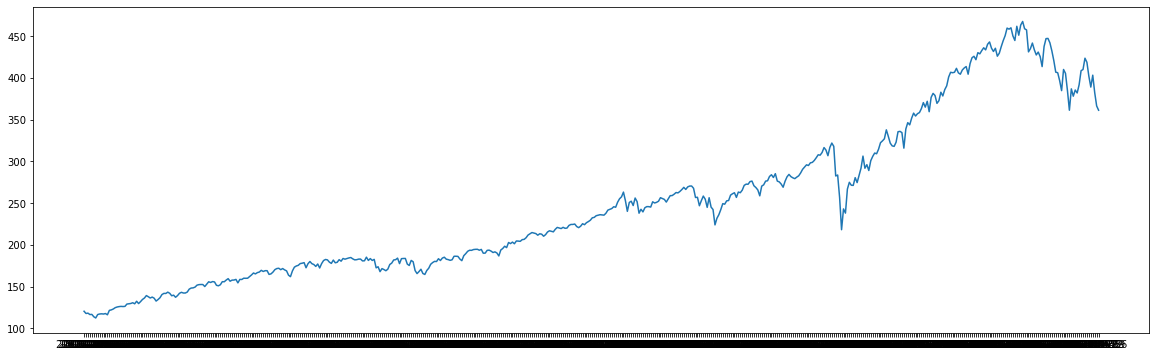

In [63]:
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(spy_df['adjclose']);

#### Returns

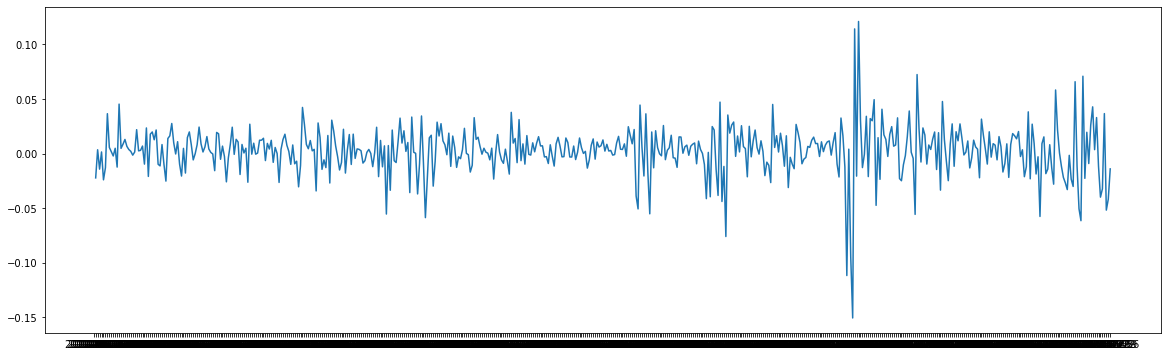

In [64]:
spy_df['ret'] = spy_df['adjclose'].pct_change()
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(spy_df['ret']);

In [65]:
rec_count=15000
spy_df['log_ret'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))
spy_df.dropna(inplace = True)
spy_df=spy_df[-rec_count:]
stock_returns = spy_df.log_ret

<AxesSubplot:xlabel='formatted_date'>

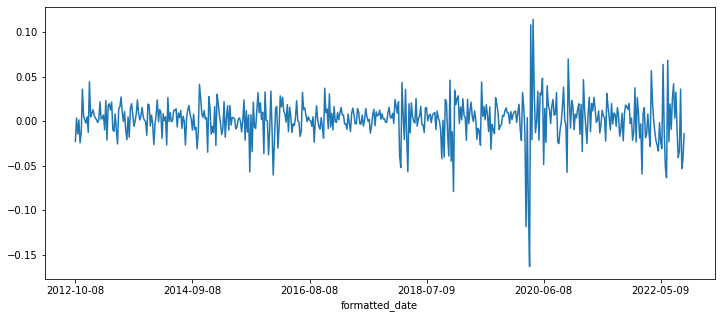

In [66]:
stock_returns.plot(figsize=(12,5))

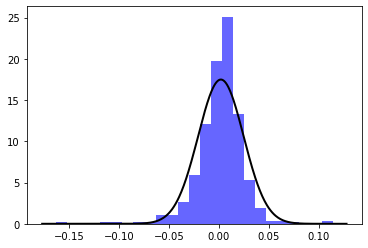

In [67]:
plt.hist(stock_returns, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
mu, std = norm.fit(stock_returns) 

x = np.linspace(xmin, xmax, len(stock_returns))
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)

#stock_returns.hist()

In [68]:
# As we can see from the histogram the returns have a kurtosis and slightly right skewed. 
# Which shows a slight deviation from Normality. We‘ll now do qqplot visualization and run the Shapiro 
# test to find if the data is normally distributed.

#### Test for Normality
##### QQPlot

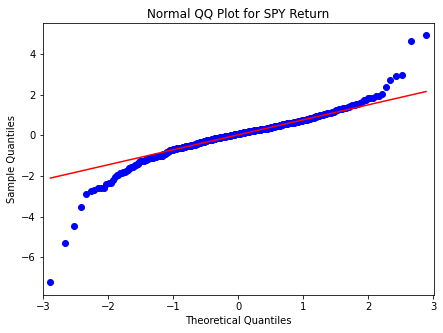

In [69]:
# Normal QQ Plot for Returns
stock_symbol = 'SPY'
qq = sm.qqplot(stock_returns,norm, fit=True, line="q")
qq.set_size_inches((7, 5))
plt.title(f"Normal QQ Plot for {stock_symbol} Return")
plt.show()

In [70]:
# As we can see from the above tests and QQ plot the returns are not normally distributed. 
# Any analysis assuming the normal distribution of the data will not be applicable to these returns.

##### Stationarity - ADF test

In [71]:
import statsmodels.tsa.stattools as st

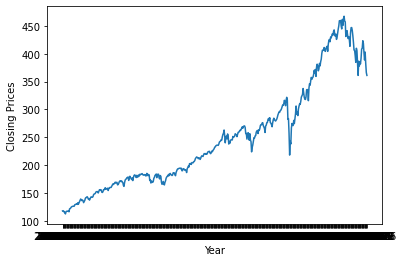

In [72]:
plt.plot(spy_df['adjclose'])
plt.ylabel("Closing Prices")
plt.xlabel("Year")
plt.show()

In [73]:
adf = st.adfuller(x=spy_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
print("adf:", adf[0], "adf_pvalue:", adf[1])

adf: -0.9463692820365538 adf_pvalue: 0.7723192548887376


In [74]:
# Here p-value is far bigger than 0.005, so we can't reject null hypothesis, and can be concluded its not stationary.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

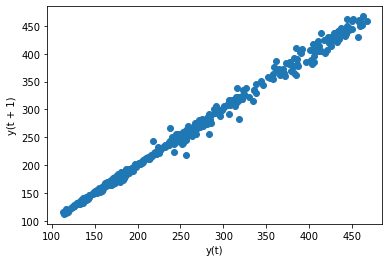

In [75]:
# lagplot for autocorrelation
pd.plotting.lag_plot(spy_df['adjclose'], lag=1)
# Correlation is calculated between the variable 
# and itself at previous time steps, such a correlation is called Autocorrelation.

#### Regime shift tests

In [76]:
from statsmodels.tsa.stattools import adfuller
adfuller(stock_returns.dropna())

(-24.467059238875088,
 0.0,
 0,
 520,
 {'1%': -3.4429882202506255,
  '5%': -2.8671142122781066,
  '10%': -2.569738849852071},
 -2354.807896803383)

#### Markov Switching Autoregressive Model

In [77]:
mod_kns = sm.tsa.MarkovRegression(stock_returns.dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                log_ret   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1334.455
Date:                Sat, 25 Feb 2023   AIC                          -2650.910
Time:                        19:18:51   BIC                          -2612.608
Sample:                    10-08-2012   HQIC                         -2635.907
                         - 09-26-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.92e-05      9.381      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008      0.000      7.325      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0091      0.005      1.887      0.059      -0.000       0.019
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9788      0.010     97.793      0.000       0.959       0.998
p[1->0]        0.0431        nan        nan        nan         nan         nan
p[2->0]     1.794e-11        nan        nan        nan         nan         nan
p[0->1]        0.0181      0.010      1.889      0.059      -0.001       0.037
p[1->1]        0.9569        nan        nan        nan         nan         nan
p[2->1]        0.1385      0.128      1.081      0.280      -0.113       0.389
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

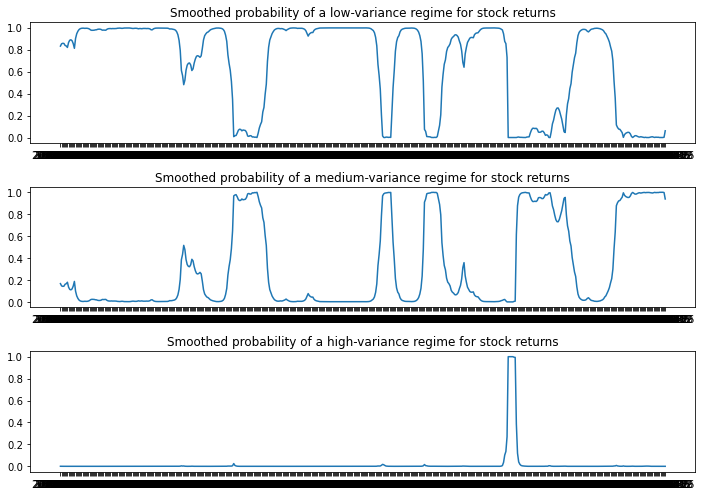

In [78]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

In [79]:
yahoo_financials = YahooFinancials('XLE')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xle_df = pd.DataFrame(data['XLE']['prices'])
xle_df = xle_df.drop('date', axis=1).set_index('formatted_date')
xle_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,74.529999,72.669998,73.940002,73.580002,57754800,50.376884
2012-10-08,74.379997,72.040001,73.169998,72.559998,49958700,49.678539
2012-10-15,75.190002,71.910004,72.430000,73.830002,60294000,50.548061
2012-10-22,74.099998,71.019997,73.860001,71.959999,57769500,49.267742
2012-10-29,72.690002,70.820000,72.250000,71.059998,31881500,48.651558


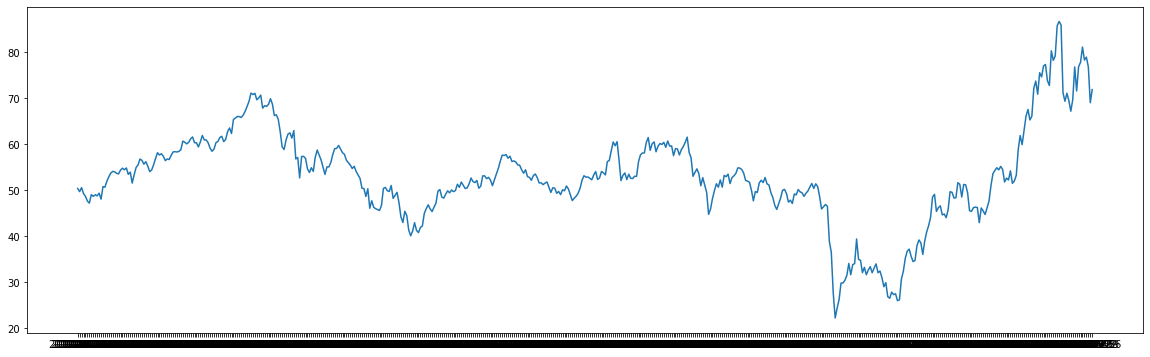

In [80]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(xle_df['adjclose']);

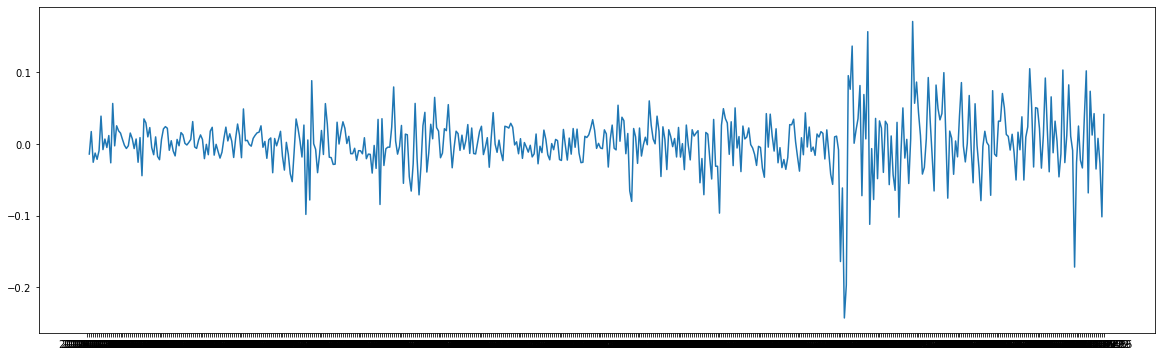

In [81]:
xle_df['ret'] = xle_df['adjclose'].pct_change()
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(xle_df['ret']);

<AxesSubplot:xlabel='formatted_date'>

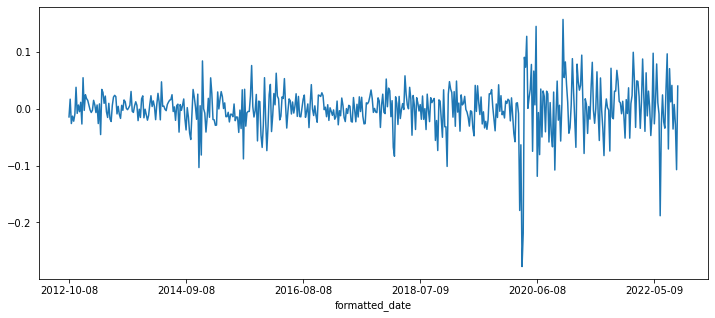

In [82]:
rec_count=20000
xle_df['log_ret'] = np.log(xle_df['adjclose'])-np.log(xle_df['adjclose'].shift(1))
xle_df.dropna(inplace = True)
xle_df=xle_df[-rec_count:]
xle_returns = xle_df.log_ret
xle_returns.plot(figsize=(12,5))

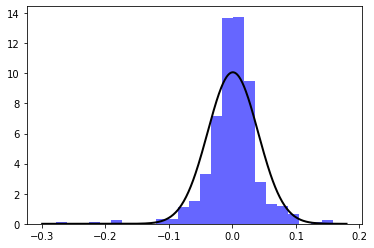

In [83]:
plt.hist(xle_returns, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
mu, std = norm.fit(xle_returns) 

x = np.linspace(xmin, xmax, len(xle_returns))
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

#xle_returns.hist()

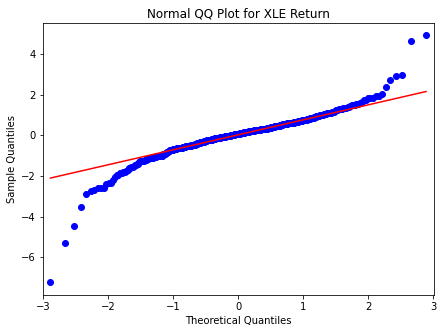

In [84]:
# Normal QQ Plot for Returns
stock_symbol = 'XLE'
qq = sm.qqplot(stock_returns,norm, fit=True, line="q")
qq.set_size_inches((7, 5))
plt.title(f"Normal QQ Plot for {stock_symbol} Return")
plt.show()

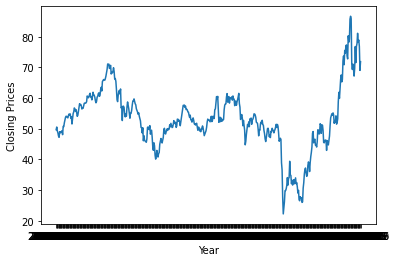

In [85]:
plt.plot(xle_df['adjclose'])
plt.ylabel("Closing Prices")
plt.xlabel("Year")
plt.show()

In [86]:
adf = st.adfuller(x=xle_df['adjclose'], regression="ct", maxlag=12) #autolag="AIC") #
print("adf:", adf[0], "adf_pvalue:", adf[1])

adf: -1.424000278822632 adf_pvalue: 0.8537286841434024


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

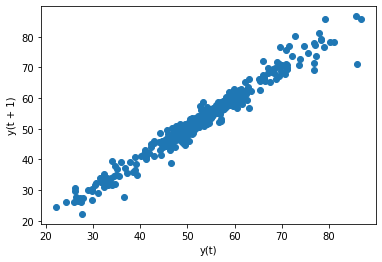

In [87]:
# lagplot for autocorrelation
pd.plotting.lag_plot(xle_df['adjclose'], lag=1)
# Correlation is calculated between the variable 
# and itself at previous time steps, such a correlation is called Autocorrelation.

In [88]:
adfuller(xle_returns.dropna())

(-8.22426512370866,
 6.308111760592279e-13,
 9,
 511,
 {'1%': -3.4432119442564324,
  '5%': -2.8672126791646955,
  '10%': -2.569791324979607},
 -1805.9525807136984)

In [89]:
mod_kns = sm.tsa.MarkovRegression(xle_returns.dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                log_ret   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1063.135
Date:                Sat, 25 Feb 2023   AIC                          -2108.269
Time:                        19:20:32   BIC                          -2069.967
Sample:                    10-08-2012   HQIC                         -2093.266
                         - 09-26-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   3.88e-05     10.487      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0023      0.000      7.925      0.000       0.002       0.003
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0149      0.007      2.150      0.032       0.001       0.029
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9822      0.008    120.817      0.000       0.966       0.998
p[1->0]        0.0261        nan        nan        nan         nan         nan
p[2->0]     1.055e-49        nan        nan        nan         nan         nan
p[0->1]        0.0143      0.007      1.913      0.056      -0.000       0.029
p[1->1]        0.9739        nan        nan        nan         nan         nan
p[2->1]        0.0755      0.078      0.964      0.335      -0.078       0.229
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

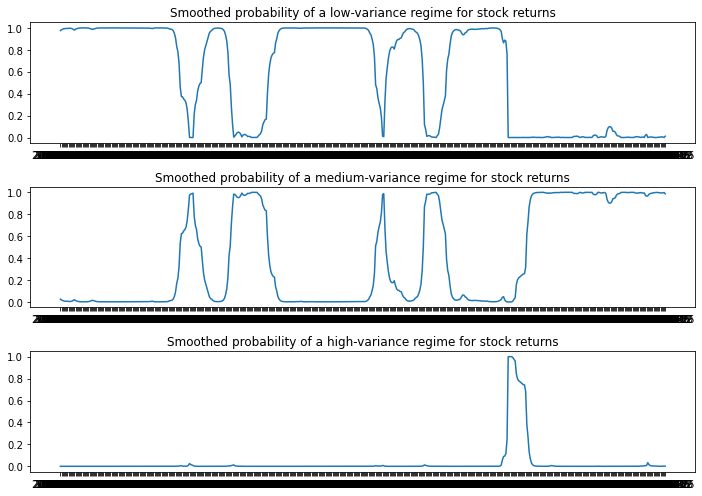

In [90]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

In [91]:
#Co

In [92]:
yahoo_financials = YahooFinancials('VNQ')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
vnq_df = pd.DataFrame(data['VNQ']['prices'])
vnq_df = vnq_df.drop('date', axis=1).set_index('formatted_date')
vnq_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,65.680000,63.820000,65.099998,65.169998,14488300,43.299473
2012-10-08,65.529999,64.680000,64.830002,64.769997,9381600,43.033695
2012-10-15,66.320000,64.459999,64.790001,65.540001,11433000,43.545311
2012-10-22,65.550003,63.400002,65.489998,63.759998,9668400,42.362637
2012-10-29,65.570000,63.740002,64.040001,65.120003,7515200,43.266239


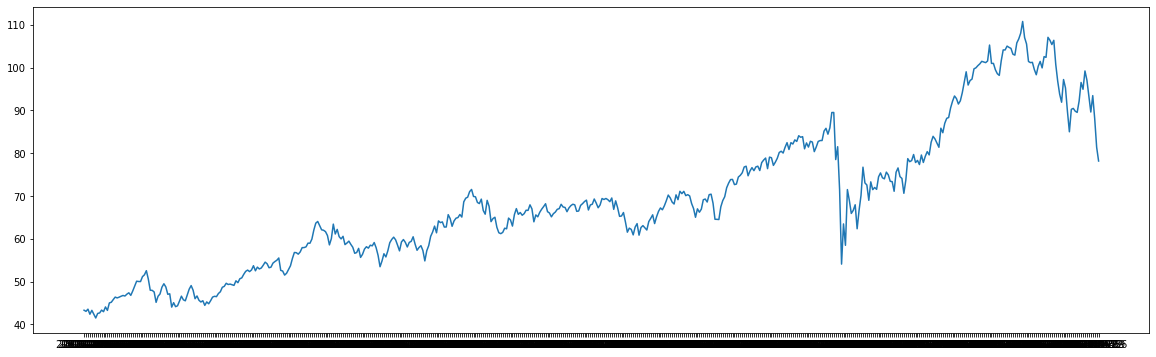

In [93]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(vnq_df['adjclose']);

In [94]:
yahoo_financials = YahooFinancials('XLF')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xlf_df = pd.DataFrame(data['XLF']['prices'])
xlf_df = xlf_df.drop('date', axis=1).set_index('formatted_date')
xlf_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,13.184403,12.688871,12.753859,13.046304,360107630,10.720534
2012-10-08,13.103168,12.802600,12.981316,12.843217,370064697,10.553655
2012-10-15,13.314379,12.835093,12.891958,13.086921,372740399,10.753912
2012-10-22,13.119415,12.745735,13.070674,12.835093,408311252,10.546978
2012-10-29,13.160032,12.826970,12.883834,12.997563,191163467,10.680490


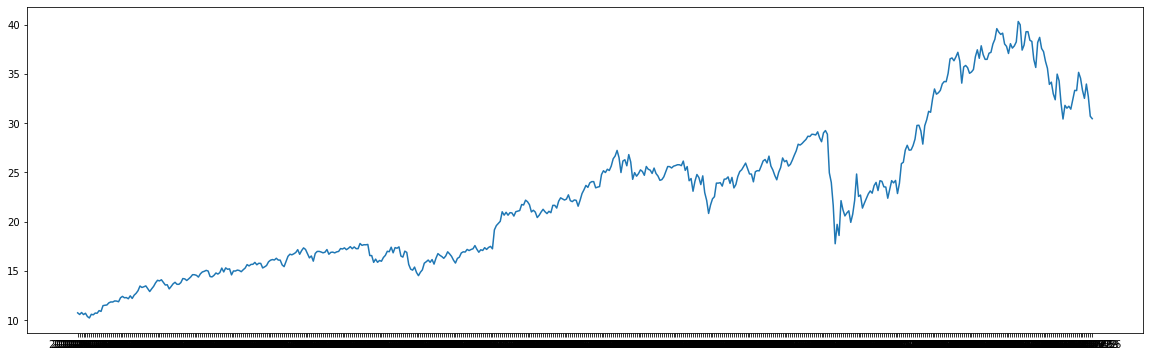

In [95]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(xlf_df['adjclose']);

In [96]:
yahoo_financials = YahooFinancials('MSCI')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
msci_df = pd.DataFrame(data['MSCI']['prices'])
msci_df = msci_df.drop('date', axis=1).set_index('formatted_date')
msci_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,36.040001,24.770000,35.970001,26.860001,26641600,24.468655
2012-10-08,26.820000,25.719999,26.740000,25.930000,5655400,23.621450
2012-10-15,27.920000,25.459999,26.129999,27.020000,9857100,24.614408
2012-10-22,27.620001,26.700001,26.860001,27.540001,3182200,25.088112
2012-10-29,28.040001,26.790001,27.510000,26.879999,2933200,24.486870


### Data Sources for various rates
Macroeconomic indicators as follows for the same time period:
1. Fed Fund effective rates
2. Bank loan rates 
3. Unemployment rates

In [97]:
from fredapi import Fred
# FRED API key
fred_key = "0e42125b8d25e5d7a6b4f26132eb7b1e";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API

fed_effective_rates_df = pd.DataFrame(fred.get_series('FEDFUNDS'));

In [98]:
fed_effective_rates_df.head()

,0
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


In [99]:
bank_loan_rates_df = pd.DataFrame(fred.get_series('DPRIME'));

In [100]:
bank_loan_rates_df.head()

,0
1955-08-04,3.25
1955-08-05,3.25
1955-08-08,3.25
1955-08-09,3.25
1955-08-10,3.25


In [101]:
unemployment_rates_df = pd.DataFrame(fred.get_series('UNRATE'));

In [102]:
unemployment_rates_df.head()

,0
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


#### Importing the libraries

In [103]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data
from datetime import datetime, timedelta
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [104]:
from bioinfokit.visuz import cluster
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.stattools as ts

In [105]:
from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_2d,compare_3d,scatter_2d,hist_1d, side_by_side
from copulas.multivariate import VineCopula

In [106]:
#Warning removal:
import warnings
warnings.filterwarnings('ignore')

#### Combined Data Sourcing

In [107]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Combining all ETFs data between Oct,2012 and Oct,2022
start = dt.datetime(2012, 10, 1)
end = dt.datetime(2022, 9, 30)

etf_tickers = ['SPY', 'VNQ', 'XLE', 'XLF']

In [108]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import yfinance as yf
from yahoofinancials import YahooFinancials

etfs = ['SPY', 'VNQ', 'XLE', 'XLF']
yahoo_financials = YahooFinancials(etfs)
etfs_data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
etfs_data

{'SPY': {'eventsData': {'dividends': {'2012-12-17': {'amount': 1.022,
     'date': 1356100200,
     'formatted_date': '2012-12-21'},
    '2013-03-11': {'amount': 0.694,
     'date': 1363354200,
     'formatted_date': '2013-03-15'},
    '2013-06-17': {'amount': 0.839,
     'date': 1371821400,
     'formatted_date': '2013-06-21'},
    '2013-09-16': {'amount': 0.838,
     'date': 1379683800,
     'formatted_date': '2013-09-20'},
    '2013-12-16': {'amount': 0.98,
     'date': 1387549800,
     'formatted_date': '2013-12-20'},
    '2014-03-17': {'amount': 0.825,
     'date': 1395408600,
     'formatted_date': '2014-03-21'},
    '2014-06-16': {'amount': 0.937,
     'date': 1403271000,
     'formatted_date': '2014-06-20'},
    '2014-09-15': {'amount': 0.939,
     'date': 1411133400,
     'formatted_date': '2014-09-19'},
    '2014-12-15': {'amount': 1.135,
     'date': 1418999400,
     'formatted_date': '2014-12-19'},
    '2015-03-16': {'amount': 0.931,
     'date': 1426858200,
     'formatted

In [113]:
combined_prices_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_prices_df['SPY'] = spy_df['adjclose']
combined_prices_df['VNQ'] = vnq_df['adjclose']
combined_prices_df['XLE'] = xle_df['adjclose']
combined_prices_df['XLF'] = xlf_df['adjclose']

In [114]:
combined_prices_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-10-08,117.839561,43.033695,49.678539,10.553655
2012-10-15,118.251907,43.545311,50.548061,10.753912
2012-10-22,116.569572,42.362637,49.267742,10.546978
2012-10-29,116.742722,43.266239,48.651558,10.680490
2012-11-05,113.938789,42.349365,47.617725,10.346720


<AxesSubplot:xlabel='formatted_date'>

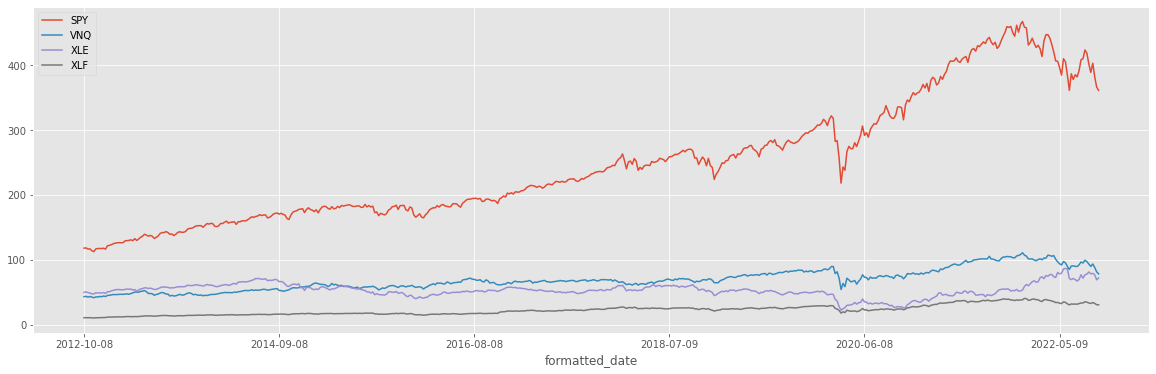

In [123]:
combined_prices_df.plot(kind='line', figsize=(20,6))

In [124]:
combined_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_rets_df['SPY'] = spy_df['adjclose'].pct_change()
combined_rets_df['VNQ'] = vnq_df['adjclose'].pct_change()
combined_rets_df['XLE'] = xle_df['adjclose'].pct_change()
combined_rets_df['XLF'] = xlf_df['adjclose'].pct_change()
combined_rets_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-10-08,NaN,-0.006138,NaN,-0.015566
2012-10-15,0.003499,0.011889,0.017503,0.018975
2012-10-22,-0.014227,-0.027160,-0.025329,-0.019243
2012-10-29,0.001485,0.021330,-0.012507,0.012659
2012-11-05,-0.024018,-0.021191,-0.021250,-0.031250


<AxesSubplot:xlabel='formatted_date'>

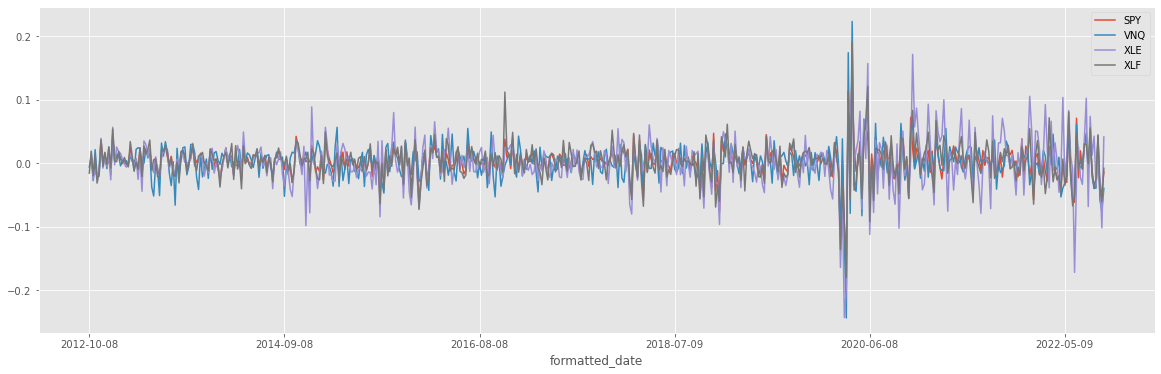

In [125]:
combined_rets_df.plot(kind='line', figsize=(20,6))

In [126]:
'''
rec_count=20000
combined_log_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_log_rets_df['SPY'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))
combined_log_rets_df['VNQ'] = np.log(vnq_df['adjclose'])-np.log(vnq_df['adjclose'].shift(1))
combined_log_rets_df['XLE'] = np.log(xle_df['adjclose'])-np.log(xle_df['adjclose'].shift(1))
combined_log_rets_df['XLF'] = np.log(xlf_df['adjclose'])-np.log(xlf_df['adjclose'].shift(1))
combined_log_rets_df.head()
spy_df['log_ret'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))
spy_df.dropna(inplace = True)
spy_df=spy_df[-rec_count:]
stock_returns = spy_df.log_ret
'''

"\nrec_count=20000\ncombined_log_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])\ncombined_log_rets_df['SPY'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))\ncombined_log_rets_df['VNQ'] = np.log(vnq_df['adjclose'])-np.log(vnq_df['adjclose'].shift(1))\ncombined_log_rets_df['XLE'] = np.log(xle_df['adjclose'])-np.log(xle_df['adjclose'].shift(1))\ncombined_log_rets_df['XLF'] = np.log(xlf_df['adjclose'])-np.log(xlf_df['adjclose'].shift(1))\ncombined_log_rets_df.head()\nspy_df['log_ret'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))\nspy_df.dropna(inplace = True)\nspy_df=spy_df[-rec_count:]\nstock_returns = spy_df.log_ret\n"

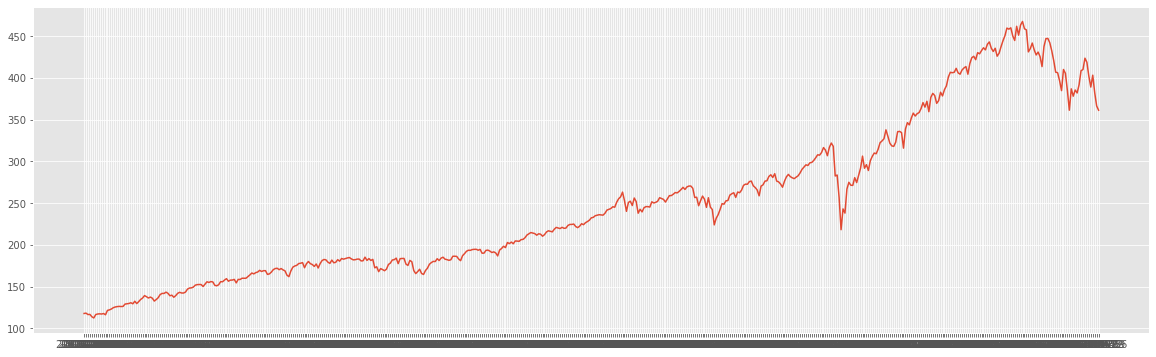

In [116]:

fig, ax = plt.subplots(figsize=(20,6));
ax.plot(combined_prices_df['SPY']);


After discussion with Kenneth Abott:
    
    1. Working with weekly data,
    2. Test for statistical distributions
    3. Do different tests including ADF
    4. Check first order serial autocorrelation
    5. Plotting graphs, correlation matrices,
    6. Check regime shift, 
    7. Basic statistical analysis from dispersion (skewness, kurtosis). 

#### Resampling

In [ ]:
#TBD

#### Gathering data from Fred for Indicators purpose

In [ ]:
#TBD

### Data Display
#### Plotting for Outliers

In [ ]:
# TBD
# Boxplot
# Correlation heat map

##### Cluster correlation analysis

In [ ]:
# TBD
# cluster correlation matrix
# Scatter plot
# Time series plot
# Density plot


#### Calculating Daily Returns

In [ ]:
# TBD

In [ ]:
# PCA Analsis
# Extreme value tracing
# Modelling Data
## QQ Plot normalization
# Jorgue -Berra Test
# QQ Plot normalization 

# Gaussian F-test
# Normalization test
# 

## Model - fitting
# Copula
# Gaussian Copula
# Normal distribution
# Non Gaussian Copula
# Model Vine Copula
# 

## Regime Tests
#  Get data 
# CADF model function
# mean reverting relationship
# 